- Dataset : http://vis-www.cs.umass.edu/lfw/#download

- Dataset Structure :

```
DATASET\
    label_name_A\
        label_name_A_001.jpg
        label_name_A_002.jpg
        label_name_A_003.jpg
        .
        .
    label_name_B\
        label_name_B_001.jpg
        label_name_B_002.jpg
        label_name_B_003.jpg
        .
        .
```

In [1]:
import os 
import cv2 
import numpy as np
import matplotlib.pyplot as plt


# disable GPU
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [2]:
#Path to the root image directory containing sub-directories of images
dataset_folder = "DATASET"

data_slice = [70, 195, 78, 172] 
# [ymin, ymax, xmin, xmax]
# to extract the `interesting` part of the image files 
# and avoid use statistical correlation from the background 

# resize ratio to reduce sample dimention
resize_ratio = 2.5

h = int((data_slice[1] - data_slice[0])/resize_ratio) #ymax - ymin slice, Height of image in float
w = int((data_slice[3] - data_slice[2])/resize_ratio) #xmax - xmin slice, Width of image in float 
print("Image dimension after resize (h,w) :", h, w)

Image dimension after resize (h,w) : 50 37


In [39]:
# minimum number of sample for each class
sample_class = 100
class_name = []

for folder in os.listdir(dataset_folder):
    if len(os.listdir(os.path.join(dataset_folder, folder))) >= sample_class:
        class_name.append(folder)

In [40]:
def print_progress(val, val_len, folder, bar_size=20):
    progr = "#"*round((val)*bar_size/val_len) + " "*round((val_len - (val))*bar_size/val_len)
    if val == 0:
        print("", end = "\n")
    else:
        print("[%s] (%d samples)\t label : %s \t\t" % (progr, val, folder), end="\r")

In [41]:
imgs = []
labels = []
for folder in class_name:
    folder_files = os.listdir(os.path.join(dataset_folder, folder))
    len_sub_folder = len(folder_files) - 1
    for i, filename in enumerate(folder_files):
        img = cv2.imread(os.path.join(dataset_folder, folder, filename))
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        croped = gray[data_slice[0]:data_slice[1], data_slice[2]:data_slice[3]]
        resized = cv2.resize(croped, (w,h))
        imgs.append(resized)
        labels.append(folder)
        
        print_progress(i, len_sub_folder, folder)


[####################] (235 samples)	 label : Colin_Powell 		
[####################] (120 samples)	 label : Donald_Rumsfeld 		
[####################] (529 samples)	 label : George_W_Bush 		
[####################] (108 samples)	 label : Gerhard_Schroeder 		


In [42]:
print("Number of samples \t: ", len(labels))
print("Number of class \t: ", len(class_name))
print("Class name \t\t: \n", class_name)

Number of samples 	:  1140
Number of class 	:  5
Class name 		: 
 ['Colin_Powell', 'Donald_Rumsfeld', 'George_W_Bush', 'Gerhard_Schroeder', 'Tony_Blair']


In [7]:
# test preview image in index 0
cv2.imshow("preview sample image", imgs[0])

cv2.waitKey(0)
cv2.destroyAllWindows()

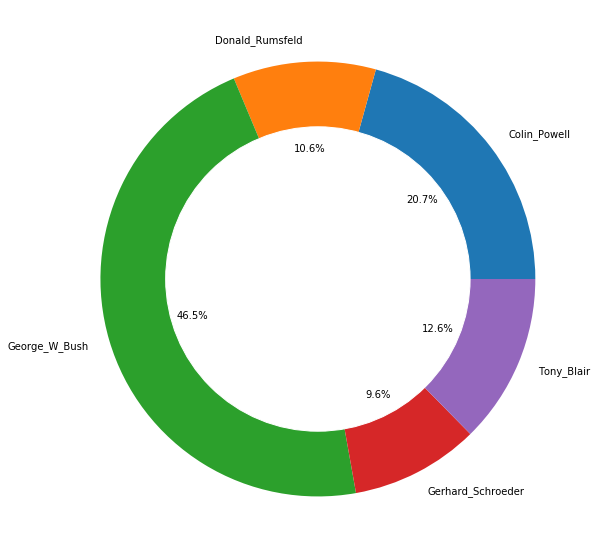

In [43]:
# preview data distribution

def print_data(label_distr, label_name):
    plt.figure(figsize=(20,10))

    my_circle = plt.Circle( (0,0), 0.7, color='white')
    plt.pie(label_distr, 
            labels=label_name,  
            autopct='%1.1f%%')

    p = plt.gcf()
    p.gca().add_artist(my_circle)
    plt.show()
    
label_distr = {i:labels.count(i) for i in labels}.values()
print_data(label_distr, class_name)

### Balancing dataset

In [44]:
n = sample_class

def randc(labels, l):
    return np.random.choice(np.where(np.array(labels) == l)[0], n, replace=False)

mask = np.hstack([randc(labels, l) for l in np.unique(labels)])

In [45]:
balanced_labels = [labels[m] for m in mask]
balanced_imgs = [imgs[m] for m in mask]

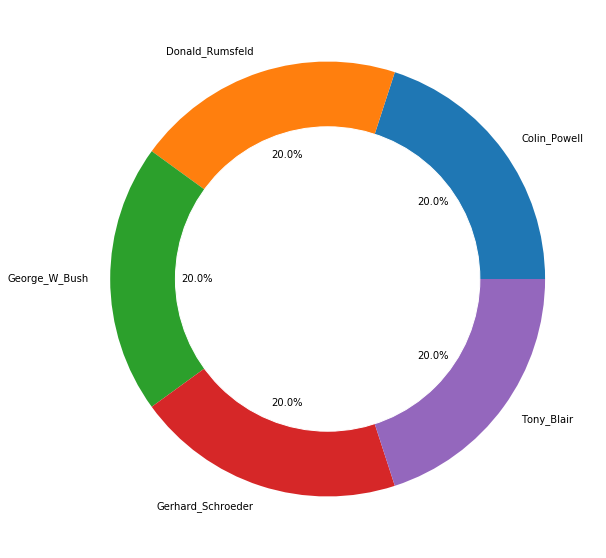

In [46]:
label_distr = {i:balanced_labels.count(i) for i in balanced_labels}.values()
print_data(label_distr, class_name)

### Prepare Dataset

In [47]:
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical

from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [48]:
X = np.array(balanced_imgs)

#### Label encoding & categoricalize output vector

In [49]:
le = LabelEncoder()
le.fit(balanced_labels)
le.classes_

array(['Colin_Powell', 'Donald_Rumsfeld', 'George_W_Bush',
       'Gerhard_Schroeder', 'Tony_Blair'], dtype='<U17')

In [50]:
Y = le.transform(balanced_labels)
Y = to_categorical(Y)

#### Split dataset

In [51]:
X_train, X_test, y_train, y_test = \
                    train_test_split(X, 
                                     Y, 
                                     test_size=0.25, 
                                     random_state=42)
  
print("Dimensi data :\n")
print("X train \t X test \t Y train \t Y test")  
print("%s \t %s \t %s \t %s" % (X_train.shape, X_test.shape, y_train.shape, y_test.shape))

Dimensi data :

X train 	 X test 	 Y train 	 Y test
(375, 50, 37) 	 (125, 50, 37) 	 (375, 5) 	 (125, 5)


### Build CNN Model

In [94]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense, Conv2D, MaxPool2D, GlobalMaxPool2D, Dropout, Flatten, Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [53]:
def resize_data(X_train, X_test):
    #
    # 4+D tensor with shape: batch_shape + (channels, rows, cols) if data_format='channels_first' or 
    # 4+D tensor with shape: batch_shape + (rows, cols, channels) if data_format='channels_last'.
    #
    if K.image_data_format() == 'channels_first':
        X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1], X_train.shape[2])
        X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1], X_test.shape[2])
        print(X_train.shape)
        input_shape = (1, X_train.shape[1], X_train.shape[2])
    else:
        X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
        X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
        print(X_train.shape)
        input_shape = (X_train.shape[1], X_train.shape[2], 1)
    return X_train, X_test, input_shape 

In [54]:
def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

In [88]:
def cnn_model(image_shape):
    opt = Adam() #learning_rate=0.001
    
    model = Sequential()
    
    model.add(Conv2D(64,
                    (3,3),
                    padding="valid",
                    activation="relu",
                    input_shape=image_shape))
    model.add(Conv2D(64,
                    (3,3),
                    padding="valid",
                    activation="relu"))
    model.add(MaxPool2D(pool_size=(2, 2)))
              
    model.add(Dropout(0.2))
    
    model.add(Conv2D(128,
                    (3,3),
                    padding="valid",
                    activation="relu"))
    model.add(Conv2D(128,
                    (3,3),
                    padding="valid",
                    activation="relu"))
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Flatten())
    
    model.add(Dropout(0.2))
    
    model.add(Dense(512, activation="relu"))
    model.add(Dense(256, activation="relu"))
    model.add(Dense(5))
    model.add(Activation("softmax"))
    
    model.summary() 
    
    model.compile(optimizer=opt, 
                  loss='categorical_crossentropy',
                  metrics = ['accuracy', precision, recall])

    return model

In [89]:
X_train, X_test, input_shape = resize_data(X_train, X_test)

EPOCHS = 30
BATCH_SIZE = 64

model = cnn_model(input_shape)


callbacks = [EarlyStopping(monitor='val_loss', patience=5),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]
    
history = model.fit(X_train, 
                      y_train,
                      epochs=EPOCHS,
                      batch_size=BATCH_SIZE,
                      callbacks=callbacks,
                      validation_data=(X_test,y_test))

model.load_weights('best_model.h5')

(375, 50, 37, 1)
Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_89 (Conv2D)           (None, 48, 35, 64)        640       
_________________________________________________________________
conv2d_90 (Conv2D)           (None, 46, 33, 64)        36928     
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 23, 16, 64)        0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 23, 16, 64)        0         
_________________________________________________________________
conv2d_91 (Conv2D)           (None, 21, 14, 128)       73856     
_________________________________________________________________
conv2d_92 (Conv2D)           (None, 19, 12, 128)       147584    
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 

375/375 [==============================] - 8s 20ms/step - loss: 0.4856 - accuracy: 0.8053 - precision: 0.7714 - recall: 0.8509 - val_loss: 0.6497 - val_accuracy: 0.7840 - val_precision: 0.7431 - val_recall: 0.7870
Epoch 28/30
375/375 [==============================] - 7s 19ms/step - loss: 0.3913 - accuracy: 0.8640 - precision: 0.8412 - recall: 0.8883 - val_loss: 0.5998 - val_accuracy: 0.7280 - val_precision: 0.7177 - val_recall: 0.7847
Epoch 29/30
375/375 [==============================] - 8s 20ms/step - loss: 0.3336 - accuracy: 0.8987 - precision: 0.8603 - recall: 0.9239 - val_loss: 0.5242 - val_accuracy: 0.8160 - val_precision: 0.7821 - val_recall: 0.8500
Epoch 30/30
375/375 [==============================] - 8s 20ms/step - loss: 0.2789 - accuracy: 0.8933 - precision: 0.8660 - recall: 0.9149 - val_loss: 0.5828 - val_accuracy: 0.8080 - val_precision: 0.7907 - val_recall: 0.8517


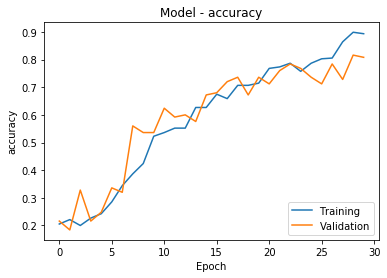

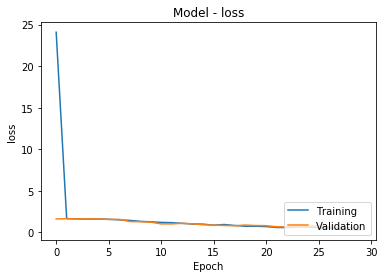

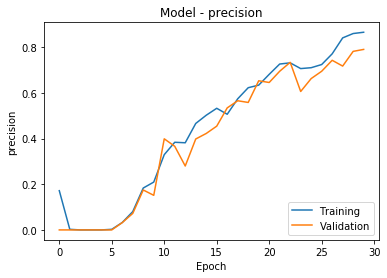

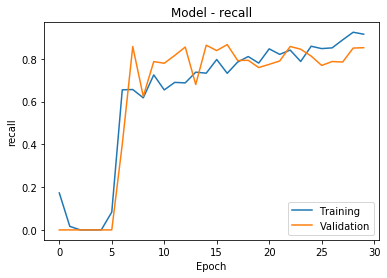

In [90]:
def evaluate_model(history):
    names = [['accuracy', 'val_accuracy'], 
             ['loss', 'val_loss'], 
             ['precision', 'val_precision'], 
             ['recall', 'val_recall']]
    for name in names :
        fig1, ax_acc = plt.subplots()
        plt.plot(history.history[name[0]])
        plt.plot(history.history[name[1]])
        plt.xlabel('Epoch')
        plt.ylabel(name[0])
        plt.title('Model - ' + name[0])
        plt.legend(['Training', 'Validation'], loc='lower right')
        plt.show()
        
evaluate_model(history)

In [91]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(10, 10))
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

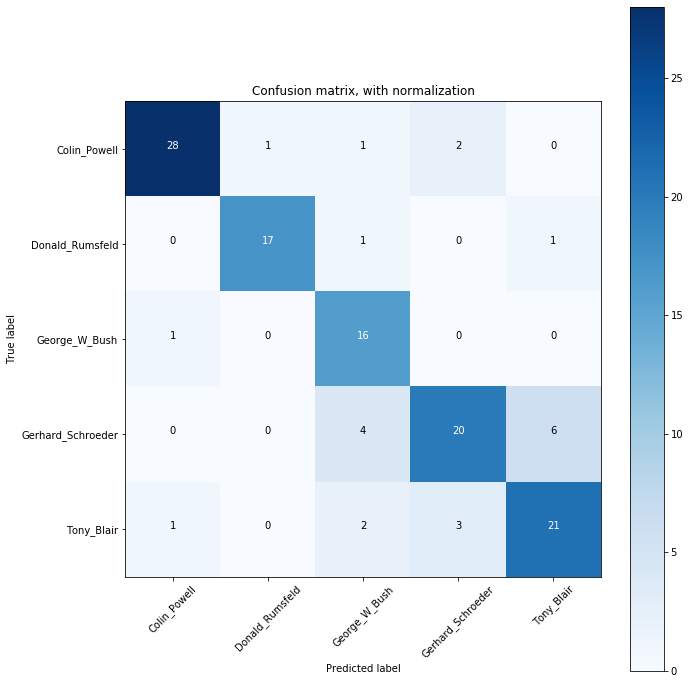

In [92]:
# predict test data
y_pred=model.predict(X_test)


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plot_confusion_matrix(cnf_matrix, 
                      classes=class_name,
                      normalize=False,
                      title='Confusion matrix, with normalization')


In [93]:
print(classification_report(y_test.argmax(axis=1), 
                            y_pred.argmax(axis=1), 
                            target_names=class_name))

                   precision    recall  f1-score   support

     Colin_Powell       0.93      0.88      0.90        32
  Donald_Rumsfeld       0.94      0.89      0.92        19
    George_W_Bush       0.67      0.94      0.78        17
Gerhard_Schroeder       0.80      0.67      0.73        30
       Tony_Blair       0.75      0.78      0.76        27

         accuracy                           0.82       125
        macro avg       0.82      0.83      0.82       125
     weighted avg       0.83      0.82      0.82       125

